In [74]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
import os
import IPython.display as display

In [75]:
import re

def parse_pbtxt(pbtxt_content):
    # Regular expressions for extracting id, name, and display_name
    id_pattern = re.compile(r'id:\s*(\d+)')
    name_pattern = re.compile(r'name:\s*"([^"]+)"')
    display_name_pattern = re.compile(r'display_name:\s*"([^"]+)"')

    label_map = []

    items = pbtxt_content.split('item {')
    for item in items:
        if not item.strip():
            continue
        
        id_match = id_pattern.search(item)
        name_match = name_pattern.search(item)
        display_name_match = display_name_pattern.search(item)
        
        if id_match and name_match:
            item_dict = {
                'id': int(id_match.group(1)),
                'name': name_match.group(1),
                'display_name': display_name_match.group(1) if display_name_match else name_match.group(1)
            }
            label_map.append(item_dict)

    return label_map

def parse_pbtxt_file(file_path):
    with open(file_path, 'r') as file:
        pbtxt_content = file.read()
    return parse_pbtxt(pbtxt_content)


In [76]:
dataset_location = 'FOOD-INGREDIENTS dataset.v4i.tfrecord'
tfrecord_name = "FOOD-INGREDIENTS.tfrecord"
pbtxt_name = "FOOD-INGREDIENTS_label_map.pbtxt"
print(os.path.exists(dataset_location))

True


In [77]:
dataset_train = tf.data.TFRecordDataset(dataset_location + f"/train/{tfrecord_name}")
# Example usage
label_map = parse_pbtxt_file(dataset_location + f"/train/{pbtxt_name}")
print(label_map)

[{'id': 1, 'name': 'Akabare Khursani', 'display_name': 'Akabare Khursani'}, {'id': 2, 'name': 'Apple', 'display_name': 'Apple'}, {'id': 3, 'name': 'Artichoke', 'display_name': 'Artichoke'}, {'id': 4, 'name': 'Ash Gourd -Kubhindo-', 'display_name': 'Ash Gourd -Kubhindo-'}, {'id': 5, 'name': 'Asparagus -Kurilo-', 'display_name': 'Asparagus -Kurilo-'}, {'id': 6, 'name': 'Avocado', 'display_name': 'Avocado'}, {'id': 7, 'name': 'Bacon', 'display_name': 'Bacon'}, {'id': 8, 'name': 'Bamboo Shoots -Tama-', 'display_name': 'Bamboo Shoots -Tama-'}, {'id': 9, 'name': 'Banana', 'display_name': 'Banana'}, {'id': 10, 'name': 'Beans', 'display_name': 'Beans'}, {'id': 11, 'name': 'Beaten Rice -Chiura-', 'display_name': 'Beaten Rice -Chiura-'}, {'id': 12, 'name': 'Beef', 'display_name': 'Beef'}, {'id': 13, 'name': 'Beetroot', 'display_name': 'Beetroot'}, {'id': 14, 'name': 'Bethu ko Saag', 'display_name': 'Bethu ko Saag'}, {'id': 15, 'name': 'Bitter Gourd', 'display_name': 'Bitter Gourd'}, {'id': 16, '

In [89]:
class_map = {item['id']: item['display_name'] for item in label_map}

In [78]:
result = {}
for raw_record in dataset_train.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    for key, feature in example.features.feature.items():
        kind = feature.WhichOneof('kind')
        result[key] = np.array(getattr(feature, kind).value)

2024-06-09 12:02:55.738341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [79]:
for key, value in result.items():
    print(key, value)

image/object/bbox/ymin [0.17812499]
image/width [640]
image/object/bbox/xmax [0.87656248]
image/encoded [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x02\x80\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4

In [80]:
feature_description = {
    'image/object/bbox/ymin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax' : tf.io.VarLenFeature(tf.float32),
    'image/object/class/text' : tf.io.VarLenFeature(tf.string),
    'image/object/class/label' : tf.io.VarLenFeature(tf.int64),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
}
def _parse_function(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    bounding_box = ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax']
    for key in ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax', 'image/object/class/text', 'image/object/class/label']:
        parsed_example[key] = tf.sparse.to_dense(parsed_example[key])
        if (key in bounding_box and "x" in key):
            parsed_example[key] = parsed_example[key] * tf.cast(parsed_example['image/width'], tf.float32)
        elif (key in bounding_box):
            parsed_example[key] = parsed_example[key] * tf.cast(parsed_example['image/height'], tf.float32)
    return parsed_example

In [81]:
def preprocess_dataset(parsed_dataset):
    image = tf.image.decode_jpeg(parsed_dataset['image/encoded'])
    label = parsed_dataset['image/object/class/label']
    bounding_box = tf.stack([
        parsed_dataset['image/object/bbox/xmin'],
        parsed_dataset['image/object/bbox/ymin'],
        parsed_dataset['image/object/bbox/xmax'],
        parsed_dataset['image/object/bbox/ymax']
    ], axis=-1)
    image = tf.cast(image, tf.float32)
    return {
        'images': image,
        'bounding_boxes' : {
            'boxes': tf.cast(bounding_box, tf.float32),
            'classes': tf.cast(label, tf.int32)
        }
    }

def visualize_data(image, bounding_boxes):
    image = image.numpy()
    image = image.astype(np.uint8)
    colors = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
    tf.image.draw_bounding_boxes(image, tf.RaggedTensor.to_tensor(bounding_boxes['boxes'], shape=(None, 4)), colors=colors)
    plt.imshow(image)
    plt.show()
    

In [82]:
augmenter = tf.keras.Sequential([
    keras_cv.layers.RandomFlip(mode='horizontal', bounding_box_format="xyxy"),
    # keras_cv.layers.RandomRotation(factor=0.1, interpolation='bilinear', bounding_box_format="xyxy"),
    # keras_cv.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, interpolation='bilinear', bounding_box_format="xyxy"),
    keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, interpolation='bilinear', bounding_box_format="xyxy"),
    # keras_cv.layers.JitteredResize(target_size=(240, 240), scale_factor=(0.8, 1.25), bounding_box_format="xyxy", interpolation='bilinear'),
    keras_cv.layers.Resizing(224, 224, bounding_box_format="xyxy", pad_to_aspect_ratio=True, interpolation='bilinear'),
])

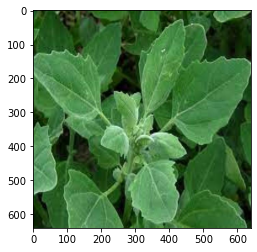

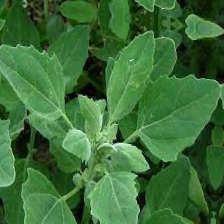

[14.]
<tf.RaggedTensor [[10.76011, 41.41125, 194.14699, 219.06783]]>


2024-06-09 12:03:03.839496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [83]:
for parsed_dataset in dataset_train.map(_parse_function).map(preprocess_dataset).take(1):
    bounding_boxes = parsed_dataset['bounding_boxes']
    image = parsed_dataset['images']
    plt.imshow(image.numpy().astype(np.uint8))
    plt.show()
    res = augmenter(parsed_dataset)
    image_augmented = res["images"]
    display.display(tf.keras.preprocessing.image.array_to_img(image_augmented))
    print(res['bounding_boxes']['classes'].numpy())
    print(res['bounding_boxes']['boxes'])

In [84]:
dataset_train = dataset_train.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_train = dataset_train.map(preprocess_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_train = dataset_train.ragged_batch(32)

In [ ]:
for image_features in dataset_train.take(3):
    display.display(tf.keras.preprocessing.image.array_to_img(image_features['images'].numpy()))
    print(image_features['bounding_boxes'])

ValueError: Expected image array to have rank 3 (single image). Got array with shape: (32, 640, 640, 3)

: 

{'boxes': <tf.RaggedTensor [[[61.0, 114.0, 561.0, 548.0]], [[183.0, 66.0, 640.0, 307.0],
                                 [1.0, 197.0, 491.0, 563.0],
                                 [113.0, 105.0, 533.0, 554.0]],
 [[0.0, 23.0, 288.0, 640.0]], [[170.0, 175.0, 339.0, 519.0]],
 [[318.0, 33.0, 493.0, 353.0],
  [163.0, 0.0, 363.0, 398.0],
  [3.0, 0.0, 194.0, 438.0],
  [495.0, 46.0, 632.0, 423.0]], [[64.0, 98.0, 329.0, 548.0],
                                 [237.0, 32.0, 463.0, 546.0]],
 [[308.0, 253.0, 434.0, 639.0],
  [27.0, 109.0, 321.0, 503.0],
  [351.0, 27.0, 589.0, 258.0]] , [[361.0, 370.0, 571.0, 522.0],
                                  [386.0, 44.0, 508.0, 102.0],
                                  [378.0, 108.0, 481.0, 168.0],
                                  [7.0, 152.0, 145.0, 245.0],
                                  [93.0, 256.0, 281.0, 340.0],
                                  [216.0, 163.0, 410.0, 227.0],
                                  [24.0, 381.0, 202.0, 462.0],
     

2024-06-09 12:04:23.140199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


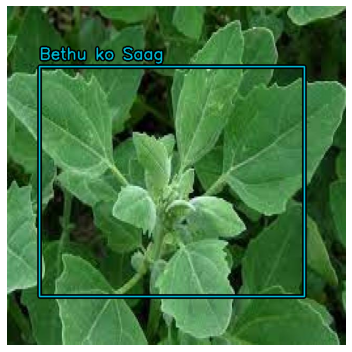

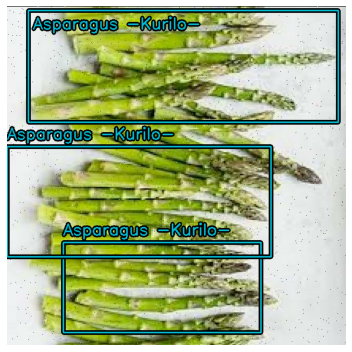

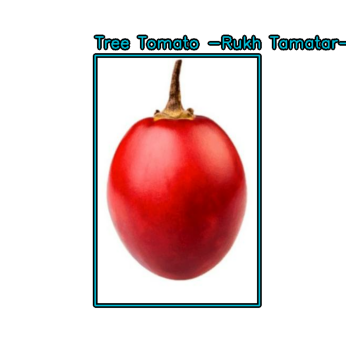

In [88]:
from keras_cv import visualization
for result in dataset_train.take(3):
    image = result['images']
    bounding_boxes = result['bounding_boxes']
    print(bounding_boxes)
    visualization.plot_bounding_box_gallery(
        result['images'],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_true=result['bounding_boxes'],
        class_mapping=class_map
    )